This Jupyter Notebook estimates the passing probabilities of step-overs and bends as a function of their geometries and generates a Poisson model for the likelihood of 31 strike-slip events given the geometrical complexity on the hosting fault systems. 

Input data: "aEQgate_geometries.csv" - csv file containing the geometries, locations, and associated slip values for all earthquake gates mapped in Rodriguez Padilla et al. (202X). See [github repository](www.github.com/absrp/passing_probabilities_EQgates) for more.

### Load Python packages and functions

In [38]:
%load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import linear_model
from scipy.optimize import curve_fit
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score, confusion_matrix
from function_file import * 
import matplotlib.transforms as mtransforms
import warnings 
warnings.filterwarnings('ignore')

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load earthquake gate geometry data

In [39]:
data = pd.read_csv('aEQgate_geometries.csv')
feature = data["Feature"].unique()
grouped = data.groupby(data.Feature)
data.head()

,FDHI ID,Earthquake,Date,Magnitude,Style,Hypocenter lat,Hypocenter lon,Feature,Breached or unbreached,Type (releasing or restraining),...,Spacing double bend (m),Type (length or angle),Location along rupture,Total rupture length,Normalized location,Distance to epicenter,Slip at gate (m),Normalized slip at gate,UTM zone,Cumulative displacement
0,4,Balochistan,'2013-09-24',7.7,Strike-Slip,26.951,65.501,bend,breached,NaN,...,0.0,angle,919.999997,199115.277475,0.004620,159516.764576,3.838833,0.239927,41N,450.0
1,4,Balochistan,'2013-09-24',7.7,Strike-Slip,26.951,65.501,bend,breached,NaN,...,0.0,angle,3529.999990,199115.277475,0.017728,156972.220664,5.416872,0.338554,41N,450.0
2,4,Balochistan,'2013-09-24',7.7,Strike-Slip,26.951,65.501,bend,breached,NaN,...,0.0,angle,7669.999970,199115.277475,0.038520,153077.215326,6.700000,0.418750,41N,450.0
3,4,Balochistan,'2013-09-24',7.7,Strike-Slip,26.951,65.501,bend,breached,NaN,...,0.0,angle,12099.999941,199115.277475,0.060769,148934.593509,10.603615,0.662726,41N,450.0
4,4,Balochistan,'2013-09-24',7.7,Strike-Slip,26.951,65.501,bend,breached,NaN,...,0.0,angle,15129.999919,199115.277475,0.075986,146027.408927,8.731105,0.545694,41N,450.0


### Fit logistic regressions through step-over and bend data with bootstrap error bounds

In [40]:
fig, axes = plt.subplots(1,3,figsize=(12,4), sharey=True)
 
log_stepover, acc_stepover, pre_stepover, f1_stepover, roc_stepover, confusion_matrix_stepover, BUbin_stepover,xstepover = build_logistic_regression(
    grouped,
    'stepover', 
    'none', 
    'length', 
    None, 
    axes[0],
    50,
    100000,
    'slategrey',
    'Step-over width (m)',
    5
)

log_bend_double, acc_bend_double, pre_bend_double, f1_bend_double, roc_bend_double, confusion_matrix_bend_double,BUbin_bend_double,xbenddouble= build_logistic_regression(grouped,'bend', 'double', 'angle',None,axes[1],0,90,'slategrey','Double bend angle ($^{\circ}$)',2.5)
log_bend_single, acc_bend_single, pre_bend_single, f1_bend_single, roc_bend_single, confusion_matrix_bend_single,BUbin_bend_single,xbendsingle = build_logistic_regression(grouped,'bend', 'single', 'angle', None,
                                                                                                                                                                           axes[2],0,90,'slategrey','Single bend angle ($^{\circ}$)',2.5)

axes[0].text(50,-0.3,'a - Step-overs',fontsize=14)
axes[1].text(0,-0.3,'b - Double bends',fontsize=14)
axes[2].text(0,-0.3,'c - Single bends',fontsize=14)

plt.tight_layout()
#plt.savefig('PP_EQgates.pdf')
plt.show()

### Analysis of earthquake likelihood and surface rupture length

Estimate event likelihood (2 cells)

In [ ]:
# Predict passing probability for each bend and step-over based on their geometry and the logistic models

feature_list = {
    'log_stepover' : log_stepover,  
    'log_bend_single': log_bend_single,
    'log_bend_double':log_bend_double
}

Passing_probability = []

for i in range(len(data)): 
    datai = data.iloc[i]
    featurei = datai['Feature']
    RRi = datai['Type (releasing or restraining)']

    if featurei == 'bend':
        RRi = datai['Type (releasing or restraining)']
        RRstr = str(RRi)

        if RRstr == 'nan':
            name_select = 'log' + '_' + 'bend' + '_' + 'single'
            extract = feature_list[name_select]
            x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
            PRi  = extract.predict_proba(x)[:,0]

        else:
            name_select = 'log' + '_' + 'bend' + '_' + 'double'
            extract = feature_list[name_select]
            x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
            PRi  = extract.predict_proba(x)[:,0]

    elif featurei == 'stepover': 
        featurestr = str(featurei)
        strlog = 'log'
        RRstr = str(RRi)
        name_select = strlog + '_' + featurestr 
        extract = feature_list[name_select]
        x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
        PRi  = extract.predict_proba(np.log10(x))[:,0] # note base 10 for logistic regression
    
    else:
        PRi = 1
        
    Passing_probability.append(PRi)

data['Passing_probability_gate'] = Passing_probability

In [ ]:
# combine the probabilities modeled for each gate of each event to estimate an event likelihood
event = data["Earthquake"]
event.unique()

mag = np.array([])
event_likelihood = np.array([])
event_group = event.unique()
SRL = np.array([])

for EQ in event_group:
    subset = data.loc[data['Earthquake'] == EQ]
    subsetb = subset.loc[subset['Breached or unbreached'] == "breached"] # only breached gates are factored into event likelihoods
    mag_i = subsetb['Magnitude']
    mag_i = mag_i.iloc[0] # select first value of magnitude since they are repeats for all rows of event
    SRLi = subsetb['Total rupture length'] # based on ECS lines in the FDHI database
    SRLi = SRLi.iloc[0] # select first value of surface rupture length since they are repeats for all rows of event

    subsetb['Passing_probability_gate'] = subsetb['Passing_probability_gate'].astype(float)
    subsetb['Passing_probability_gate_log'] = np.log(subsetb['Passing_probability_gate'])   
    event_likelihood_i = np.sum(subsetb['Passing_probability_gate_log'])

    print(mag_i,EQ,event_likelihood_i,SRLi) # book keeping

    event_likelihood = np.append(event_likelihood, event_likelihood_i)
    mag = np.append(mag,mag_i)
    SRL = np.append(SRL,SRLi)


7.7 Balochistan -7.520106770510128 199115.277475184
6.63 Borrego -3.9928780933816768 31546.4857015686
6.19 ChalfantValley -0.3023621526710293 14207.5427349576
7.0 Darfield -1.8379362910374117 28896.3939931895
7.9 Denali -7.528428457368367 278702.916265388
7.14 Duzce -2.692066203991978 40018.847231306
6.22 ElmoreRanch -0.3271357158534919 8899.97956202332
5.2 GalwayLake -0.5695487350535393 6900.28452126802
7.13 HectorMine -3.1094413060535975 48174.1492813072
6.4 Hualien -1.0680018000093827 7305.71812073165
6.95 Imperial1940 -0.5147484079634359 60614.751301348
6.53 Imperial1979 -1.5319234675632596 32653.1156479598
7.51 Izmit_Kocaeli -2.4579516172496803 121770.934867524
6.5 IzuPeninsula -0.2866322633165168 5501.24642743068
6.9 Kobe -0.5766373322717527 10101.7645342178
7.0 Kumamoto -2.058195182339417 31578.8204966148
7.28 Landers -5.253535444505012 84722.12096402
7.7 Luzon -8.51227684138976 117824.691193508
6.0 Napa -1.1237222145685863 22219.9745137025
7.0 Neftegorsk -0.9897460784924783 385

Probability of ending at a straight segment

In [ ]:
n_ends_no_gates = 12
total_SRL = np.sum(SRL)
p_straight = n_ends_no_gates/total_SRL
p_continue_straight = 1-p_straight

Plot event likelihood versus surface rupture length and different models

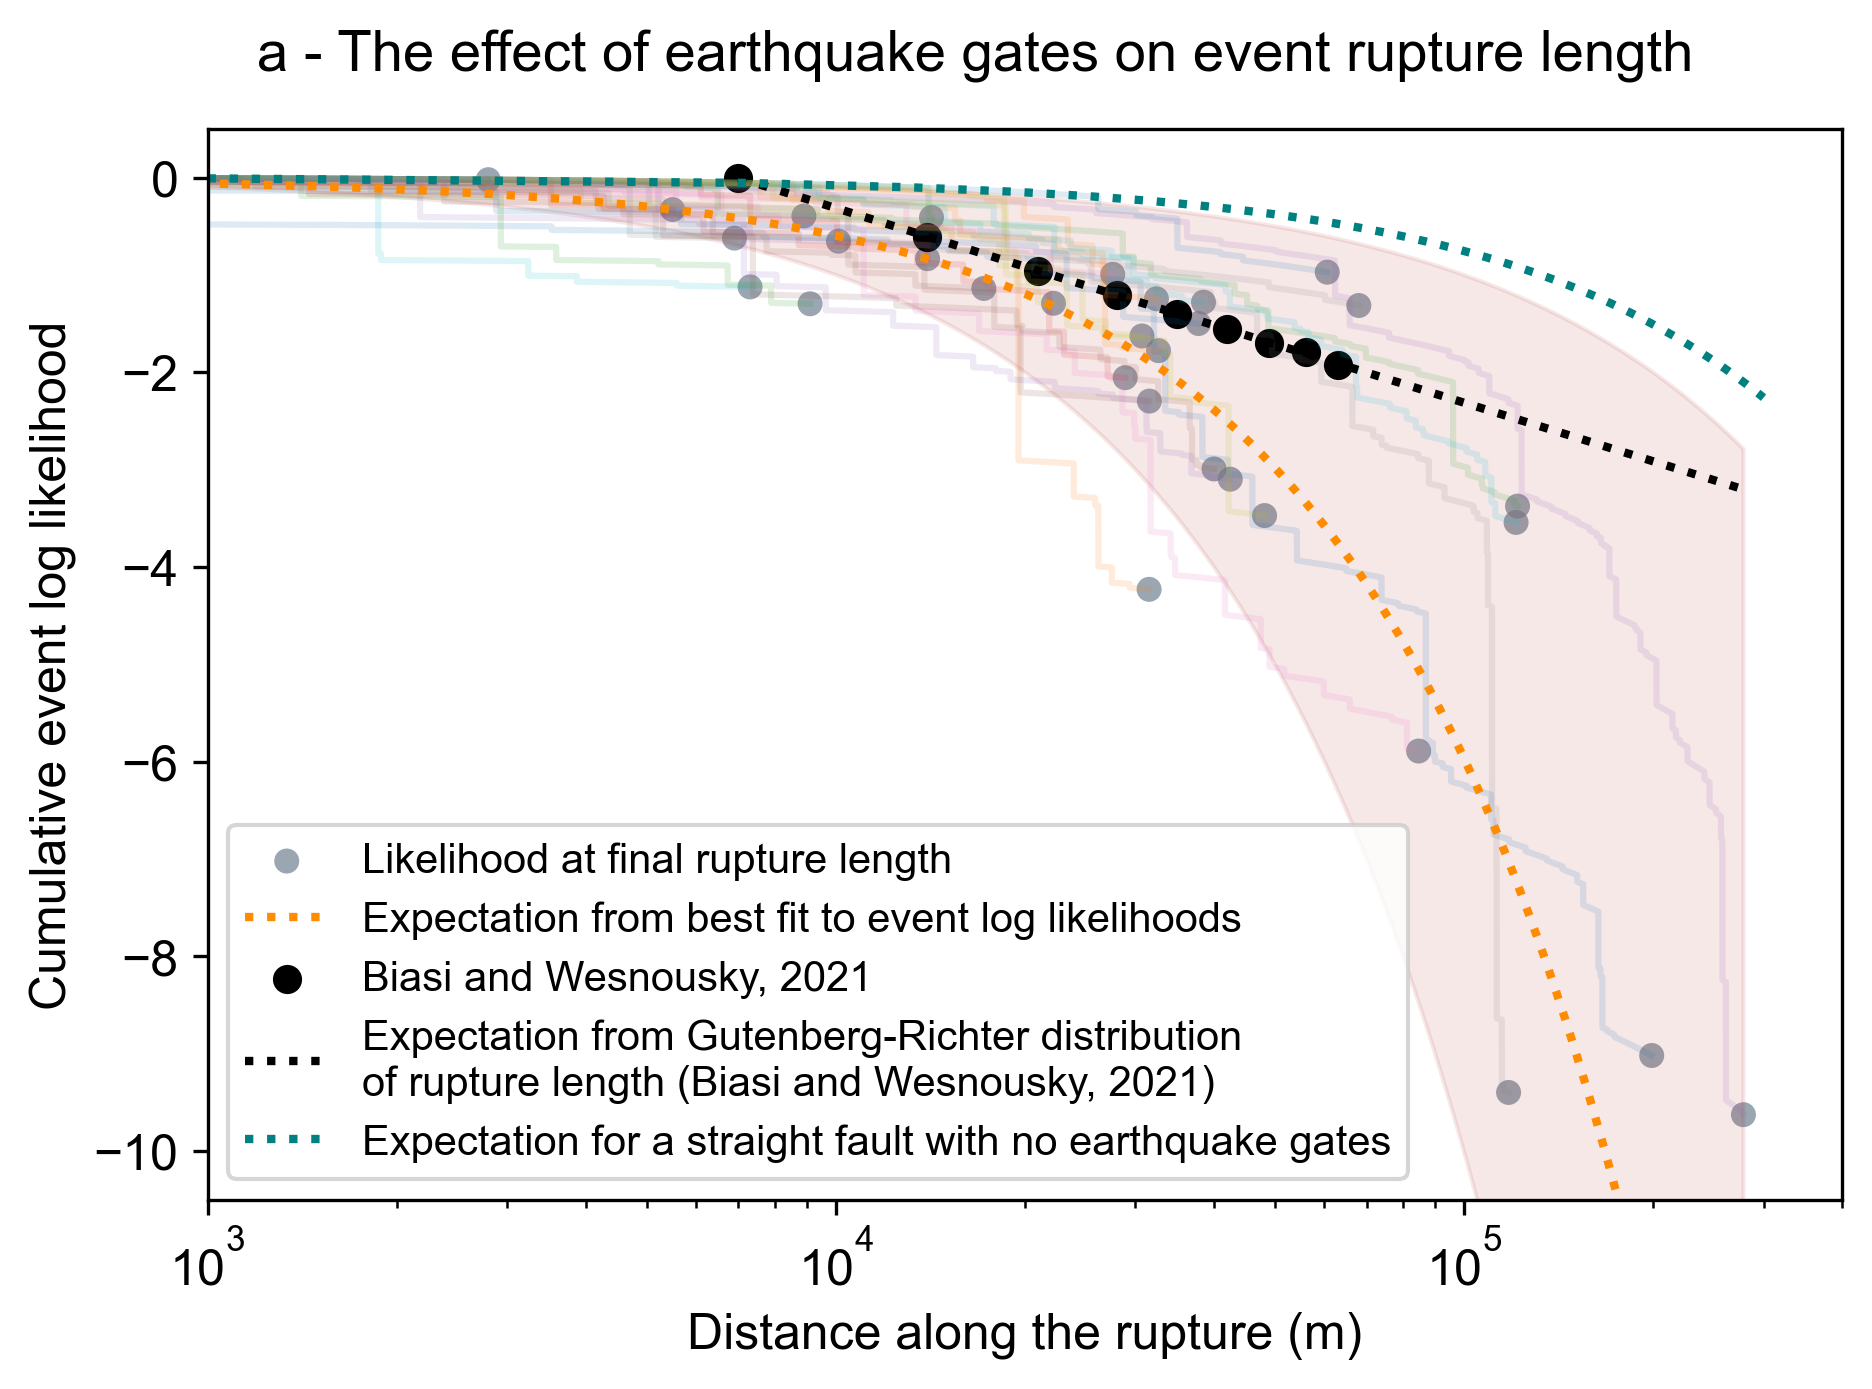

In [ ]:
######################################################## cumulative probability

lastpt = [] # last point on surface rupture or total surface rupture length
keeplikelihood = event_likelihood+np.log(p_continue_straight)*(SRL-len(event_likelihood)) # final event likelihood

# cumulative event likelihood:
plt.figure(dpi=300)
for EQ in event_group:
    subset = data.loc[data['Earthquake'] == EQ]
    subsetb = subset.loc[subset['Breached or unbreached'] == "breached"]
    subsetb = subsetb.reset_index(drop=True)
    subsetb['Passing_probability_gate'] = subsetb['Passing_probability_gate'].astype(float)

    gatelikelihood = subsetb['Passing_probability_gate']
    gateloglikelihood = np.log(subsetb['Passing_probability_gate'])
    
    gateloc = subsetb['Location along rupture']
    subsetb['Approx_Location'] = subsetb['Location along rupture'].round().astype(int)

    SRL_event = subsetb['Total rupture length']   
    surf_length = SRL_event[0]
    surf_length = round(surf_length)
    probframe = pd.DataFrame()
    SRL_points = list(range(surf_length))
    new_rows = pd.DataFrame({'surf_length': SRL_points})
    probframe = probframe.append(new_rows, ignore_index=True)
    probframe['prob_straight_segment'] = p_continue_straight
    merged_df = pd.merge(probframe, subsetb, left_on='surf_length', right_on='Approx_Location', how='left')
    merged_df['prob'] = merged_df.apply(lambda row: row['Passing_probability_gate'] if not pd.isnull(row['Passing_probability_gate']) else row['prob_straight_segment'], axis=1)
    merged_df['cumulative_sum'] = np.log(merged_df['prob']).cumsum()
    lastpt.append(max(SRL_points))

    sns.lineplot(data=merged_df,x=merged_df['surf_length'],y=merged_df['cumulative_sum'],palette="blend:#7AB,#EDA",alpha=0.15) 

plt.scatter(lastpt,keeplikelihood,c='slategrey',edgecolor='none',alpha=0.7,label='Likelihood at final rupture length',linewidth=1.3)
lastpt = np.array(lastpt) # for fitting model later
keeplikelihood = np.array(keeplikelihood)

plt.ylabel('Cumulative event log likelihood')
plt.xlabel('Distance along the rupture (m)')
plt.xlim([10**3, 400*10**3])

# fit exponential relationship through modeled final event likelihoods
y = np.array(keeplikelihood)
slope = np.mean(y / lastpt)
x_range = np.linspace(1, max(lastpt), 1000)
y_range = slope * x_range + 0

# standard error on the slope
predicted_y =  slope * lastpt + 0
residuals = y - predicted_y
SSR = np.sum(residuals**2)
var_x = np.var(lastpt)
SE_slope = np.sqrt(SSR / ((len(lastpt) - 2) * np.sum((lastpt - np.mean(lastpt))**2)))

plt.plot(x_range, y_range, label='Expectation from best fit to event log likelihoods', linestyle=':',linewidth=2,c='darkorange')
plt.xscale('log')

plt.tick_params(axis='x', labelsize=12)
plt.text(1200,1.1,'a - The effect of earthquake gates on event rupture length',fontsize=13.5)

# bracketing for understanding role of characteristic length scale
x0_low = 10**4
x0_high = 10**5
y0 = np.log(np.exp(-x_range/x0_low))
y1 = np.log(np.exp(-x_range/x0_high))

plt.fill_between(x_range,y0,y1,color='firebrick',alpha=0.1)

# add Gutenberg-Richter prediction
GR_ratio = np.log10(np.array([1, 0.246, 0.110, 0.062, 0.040, 0.028, 0.020, 0.016, 0.012]))  # from Biasi and Wesnousky, 2021
SRL_GR = np.array([7, 14, 21, 28, 35, 42, 49, 56, 63])  # from Biasi and Wesnousky, 2021
# fit pwl through GR data in Table 1 of Biasi and Wesnousky, 2021
popt, pcov = curve_fit(power_law, SRL_GR*10**3, GR_ratio)
xfit = np.linspace(min(SRL_GR*10**3),max(lastpt), 10000)
yfit = power_law(xfit, *popt)
legend_string = r'Expectation from Gutenberg-Richter distribution' + '\n' + 'of rupture length (Biasi and Wesnousky, 2021)'

# plt.scatter(SRL_GR*10**3,GR_ratio,c='black',label='Biasi and Wesnousky, 2021')
plt.plot(xfit, yfit, label=legend_string,linestyle=':',linewidth=2,c='black')

# add straight fault prediction
SRL_range = np.linspace(1000,3*10**5)
p_straight_fault = np.log(p_continue_straight)*SRL_range
plt.plot(SRL_range, p_straight_fault, label='Expectation for a straight fault with no earthquake gates', linestyle=':',linewidth=2,c='teal')
plt.legend(fontsize=10)
plt.ylim(-10.5,0.5)
plt.tight_layout()
#plt.savefig('GRL/SRL_likelihood.pdf')
plt.show()